
# 1. Getting Started- Loading the data and python packages

## 1.1. Loading the python packages

In [ ]:
pip install shap

In [ ]:
pip install pyod

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime

import lightgbm as lgb
import shap

#Import Model Packages
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score, accuracy_score, classification_report
from sklearn import cluster, covariance, manifold


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle

#The warnings
import warnings
warnings.filterwarnings('ignore')

set_option('display.width', 100)

In [ ]:
# Package for google colab management
from google.colab import drive

# Montage du dossier drive pour nous permet la recupearation de notre dataset
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2. Loading the Data


In [ ]:
# load dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/train.csv', sep = ";")
data = data[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing','loan']]
data.head(3)
print(data.shape)

(45211, 8)


In [ ]:
data_embedding = pd.read_csv("/content/drive/MyDrive/Datasets/embedding_train.csv")
data_embedding.head(3)

0         1         2         3         4         5         6         7         8  \
0  0.104805  0.023607  0.061273  0.029252 -0.043995  0.020091 -0.068435 -0.025573 -0.014535   
1  0.101677  0.024271  0.060917  0.026748 -0.066198 -0.006418 -0.023149 -0.012678 -0.057081   
2  0.130962  0.020829  0.033584  0.005326 -0.039184  0.007614 -0.039972 -0.022380 -0.047966   

          9  ...       374       375       376       377       378       379       380       381  \
0  0.022278  ...  0.036941  0.009803  0.065293 -0.003518 -0.050390 -0.022246  0.149764 -0.037173   
1 -0.006890  ...  0.027683  0.018754  0.051085 -0.015558 -0.065183 -0.031470  0.144798 -0.018689   
2  0.018000  ...  0.037228 -0.004588  0.053509  0.017749 -0.025011 -0.053403  0.146620 -0.025246   

        382       383  
0 -0.009591  0.034286  
1 -0.008655  0.032689  
2 -0.007032  0.030138  

[3 rows x 384 columns]

# 2. Preprocessing

For our modelling , we are going to use **K-means** algorithm with is very sensitive to outliers.  So, it is extremely important to remove them.

We could use **z-score method**  but  we are going to use another much more advanced and cool method. To be more specific we will use the **ECOD method** (“empirical cumulative distribution functions for outlier detection”).

This method seeks to obtain the distribution of the data and thus know which are the values ​​where the probability density is lower (outliers).

It is available in the library named  `Python Outlier Detection (PyOD) library`(For more, here is the Github [link](https://github.com/yzhao062/pyod)).


In [ ]:
from pyod.models.ecod import ECOD

clf = ECOD()
clf.fit(data_embedding)
out = clf.predict(data_embedding)


In [ ]:
data_embedding["outliers"] = out
data["outliers"] = out

df_embedding_good = data_embedding[data_embedding["outliers"] == 0]
df_embedding_good = df_embedding_good.drop(["outliers"], axis = 1)


df_embedding_all = data_embedding.copy()
df_embedding_all = df_embedding_all.drop(["outliers"], axis = 1)

In [ ]:
print(df_embedding_good.shape)

print(df_embedding_all.shape)

(40690, 384)
(45211, 384)


# 3. Evaluate Algorithms and Models
In this step, we are going to perform the **K-means** algorithm on our **Embedding dataset**.

## 3.1 Finding optimal number of clusters



In [1]:
inertia = []

k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_embedding_good)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of square error')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

NameError: name 'KMeans' is not defined

## 3.2. Clustering

In [ ]:
nclust= 5

In [ ]:
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(df_embedding_good)

In [ ]:
target_labels = k_means.predict(df_embedding_good)

In [ ]:
from sklearn import metrics
print("kmeans", metrics.silhouette_score(df_embedding_good, target_labels, metric='euclidean'))

# 4. Visualization

## 4.1 PCA

For visualizations, we can use the method to reduce dimensionality, PCA. For them we are going to use the Prince library, focused on exploratory analysis and dimensionality reduction. If you prefer, you can use Sklearn’s PCA, they are identical.

In [ ]:
pca_3d_object, df_pca_3d = get_pca_3d(df_embedding_good, target_labels)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)


The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0             70.858        18.45%                     18.45%
1             49.906        13.00%                     31.45%
2             42.915        11.18%                     42.62%


In [ ]:
pca_2d_object, df_pca_2d = get_pca_2d(df_embedding_good, target_labels)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.5)

## 4.2 t-SNE

In [ ]:
from sklearn.manifold import TSNE

sampling_data = df_embedding_good.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(k_means.labels_).sample(frac=0.5, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(
                  n_components=3,
                  learning_rate=500,
                  init='random',
                  perplexity=200,
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, title = "PCA Space", opacity=1, width_line = 0.1)

In [ ]:
from sklearn.manifold import TSNE

sampling_data = df_embedding_good.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(k_means.labels_).sample(frac=0.5, replace=True, random_state=1)[0].values

In [ ]:
df_tsne_2d = TSNE(
                  n_components=2,
                  learning_rate=500,
                  init='random',
                  perplexity=200,
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
df_tsne_2d["cluster"] = sampling_clusters

plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=1, width_line = 0.5)

# 5. Cluster Intuition

In the next step, we will check each cluster and understand the intuition behind the clusters.

In [ ]:
data_good = data[data["outliers"] == 0]
data_good = data_good.drop("outliers", axis = 1)

In [ ]:
data_good.head(3)

age          job  marital  education default  balance housing loan
0   58   management  married   tertiary      no     2143     yes   no
1   44   technician   single  secondary      no       29     yes   no
3   47  blue-collar  married    unknown      no     1506     yes   no

In [ ]:
model_lgb = lgb.LGBMClassifier(colsample_by_tree=0.8)

for col in ["job", "marital", "education", "housing", "loan", "default"]:
    data_good[col] = data_good[col].astype('category')

model_lgb.fit(X = data_good , y = target_labels)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 40690, number of used features: 8
[LightGBM] [Info] Start training from score -1.097679
[LightGBM] [Info] Start training from score -1.717423
[LightGBM] [Info] Start training from score -1.462511
[LightGBM] [Info] Start training from score -2.001780
[LightGBM] [Info] Start training from score -2.119608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_by_tree=0.8)

In [ ]:
y_pred = model_lgb.predict(data_good)
accuracy=accuracy_score(y_pred, target_labels)

print('Training-set accuracy score: {0:0.4f}'. format(accuracy))
print(classification_report(target_labels, y_pred))

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
Training-set accuracy score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13576
           1       1.00      1.00      1.00      7305
           2       1.00      1.00      1.00      9426
           3       1.00      1.00      1.00      5497
           4       1.00      1.00      1.00      4886

    accuracy                           1.00     40690
   macro avg       1.00      1.00      1.00     40690
weighted avg       1.00      1.00      1.00     40690



Usage of Shap of interpretability

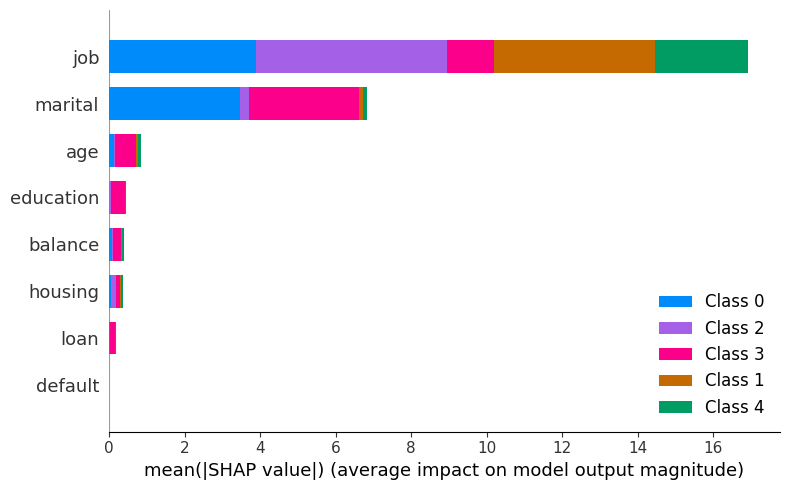

In [ ]:
explainer_km = shap.TreeExplainer(model_lgb)
shap_values_km = explainer_km.shap_values(data_good)
shap.summary_plot(shap_values_km, data_good, plot_type="bar", plot_size=(8, 5))

In [ ]:
data_good["cluster"] = target_labels

data_grouped = data_good.groupby('cluster').agg(
    {
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        'age':'mean',
        'balance': 'mean',
        'default': lambda x: x.value_counts().index[0],

    }
).sort_values("job").reset_index()

data_grouped

cluster          job  marital  education housing loan        age      balance default
0        4       admin.  married  secondary     yes   no  39.325624  1121.326852      no
1        2  blue-collar  married  secondary     yes   no  40.040420  1056.492680      no
2        0   management  married   tertiary      no   no  45.657852  1629.067104      no
3        3   management   single   tertiary      no   no  33.953975  1431.443515      no
4        1   technician  married  secondary     yes   no  39.339357  1207.394251      no

In [ ]:
data_grouped.shape

(5, 9)

In [ ]:
cluster_output = pd.concat([pd.DataFrame(data_good), pd.DataFrame(target_labels, columns = ['cluster'])],axis = 1)
cluster_output.head(3)

age          job  marital  education default  balance housing loan  cluster
0  58.0   management  married   tertiary      no   2143.0     yes   no      0.0
1  44.0   technician   single  secondary      no     29.0     yes   no      2.0
3  47.0  blue-collar  married    unknown      no   1506.0     yes   no      0.0

# Conclusion


In [ ]:
 pip install prince

In [ ]:
import prince
from sklearn.decomposition import PCA
import plotly.express as px


def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(
          df,
          x='comp1',
          y='comp2',
          z='comp3',
          color='cluster',
          template="plotly",

          # symbol = "cluster",

          color_discrete_sequence=px.colors.qualitative.Vivid,
          title=title).update_traces(
              # mode = 'markers',
              marker={
                  "size": 4,
                  "opacity": opacity,
                  # "symbol" : "diamond",
                  "line": {
                      "width": width_line,
                      "color": "black",
                  }
              }
          ).update_layout(
                  width = 800,
                  height = 800,
                  autosize = True,
                  showlegend = True,
                  legend=dict(title_font_family="Times New Roman",
                              font=dict(size= 20)),
                  scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                              yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                              zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                  font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()



def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()


    fig = px.scatter(df,
                        x=columns[0],
                        y=columns[1],
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800,
                                height = 700,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()